In [1]:
#Assignment 6
#Development of optimal smoothing to increase the estimation accuracy
#Team 12
#Yaroslav Savotin, Elizaveta Pestova, Selamawit Asfaw
#Skoltech, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#------------№1------------
# Initial parameters
N = 200
M = 500
T = 1

#For plots
step = np.arange(N)
step1 = np.arange(N - 3)

sigma = 0.2**2
sigma1 = 20**2


# Initial position and velocity
x0 = np.array([[5], [1]])

# Transition Matrix
Fi = np.array([[1, T], [0, 1]])

# Input Matrix
G = np.array([[(T**2)/2], [T]])

# Observer Matrix
H = np.array([[1], [0]])

# Initial filter estimates
X0 = np.array([[2], [0]])

# Initial filtration error covariance matrices
P0 = np.array([[10000, 0],
               [0, 10000]])

# Process noise matrix Q
Q = G * G.T * sigma

# Measurement noise
R = sigma1

In [3]:
def generate_Xt(x0, sigma, Fi, G, N):
    a = np.random.normal(0, np.sqrt(sigma), size=(1, 1, N))
    Xt = np.zeros((2, 1, N))
    Xt[:, :, 0] = x0

    for i in range(1, N):
        Xt[:, :, i] = np.dot(Fi, Xt[:, :, i-1]) + G * a[:, :, i-1]

    return Xt

def generate_Z(sigma1, Xt, H, N):
    nu = np.random.normal(0, np.sqrt(sigma1), size=(1, 1, N))
    Z = np.zeros((1, 1, N))

    for i in range(N):
        Z[:, :, i] = np.dot(H.T, Xt[:, :, i]) + nu[:, :, i]

    return Z

#------------№2------------
def kalmanFilter(Fi, H, Q, R, X0, P0, Z, N):
    Xp = np.zeros((2, 1, N)) #Prediction of state vector at time i using  (i-1) measurements
    Pp = np.zeros((2, 2, N)) #Prediction error covariance matrix 
    Xf = np.zeros((2, 1, N)) #Improved estimate by incorporating 
    K = np.zeros((2, 1, N)) #Filter gain, weight of residual
    Pf = np.zeros((2, 2, N)) #Filtration error covariance matrix
    Ps = np.zeros((1, 1, N)) 
    
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    for i in range(1, N):
        #Prediction
        Xp[:, :, i] = np.dot(Fi, Xf[:, :, i-1])
        Pp[:, :, i] = np.dot(np.dot(Fi, Pf[:, :, i-1]), Fi.T) + Q
        
        #Filtration Adjustment
        K[:, :, i] = np.dot(Pp[:, :, i], H)/(np.dot(np.dot(H.T, Pp[:, :, i]), H) + R)
        Xf[:, :, i] = Xp[:, :, i] + np.dot(K[:, :, i], Z[:, :, i] - np.dot(H.T, Xp[:, :, i])) # np.dot(H, Xp[:, i])
        Pf[:, :, i] = np.dot((np.eye(2) - np.dot(K[:, :, i], H.T)), Pp[:, :, i])
        # FOR TASK 6,11 square root of the first diagonal element of Pi,i 
        #that corresponds to standard deviation of estimation error of coordinate xi
        Ps[:, :, i] = np.sqrt(np.abs(np.diag(Pf[:, :, i])[0]))

    return Xf, Pf, K, Ps, Pp

In [4]:
# Generate true trajectories
Xt = generate_Xt(x0, sigma, Fi, G, N)

# Generate measurement trajectories
Z = generate_Z(sigma1, Xt, H, N)

In [5]:
# Calculate the estimation for true trajectories using Kalman filter
Xf, Pf, K, Ps, Pp = kalmanFilter(Fi, H, Q, R, X0, P0, Z, N)

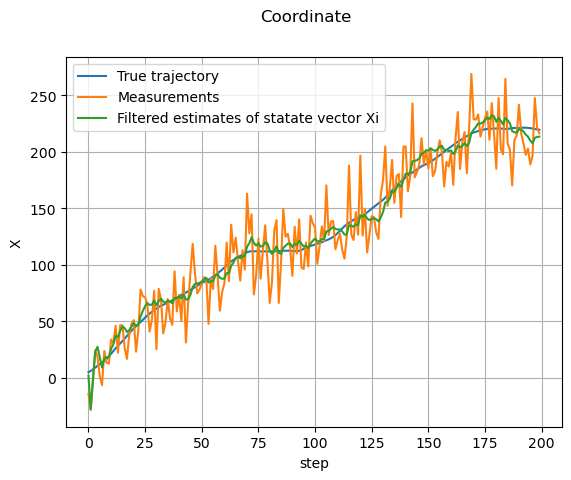

In [6]:
y1 = Xt[0][0]
y2 = Z[0][0]
y3 = Xf[0][0]
x = step
plt.plot(x,y1,label = 'True trajectory')
plt.plot(x,y2,label = 'Measurements')
plt.plot(x,y3,label = 'Filtered estimates of statate vector Xi')
plt.xlabel('step')
plt.ylabel('X')
plt.suptitle('Coordinate')
plt.legend()
plt.grid(True)

In [7]:
#------------№3------------
def kalmanFilter_Backward(Fi, H, Q, R, X0, P0, Z, N):
    Pb = np.zeros((2, 2, N))
    A = np.zeros((2, 2, N))
    Xb = np.zeros((2, 1, N))
    
    Xf, Pf, K, Ps, Pp = kalmanFilter(Fi, H, Q, R, X0, P0, Z, N)
    
    Pb[:, :, N-1] = Pf[:, :, N-1]
    Xb[:, :, N-1] = Xf[:, :, N-1]
    
    for i in range(N-2, -1, -1):
        A[:, :, i] = np.dot(np.dot(Pf[:, :, i], Fi.T), np.linalg.inv(Pp[:, :, i+1]))
        Xb[:, :, i] = Xf[:, :, i] + np.dot(A[:, :, i], (Xb[:, :, i+1] - np.dot(Fi, Xf[:, :, i])))
        Pb[:, :, i] = Pf[:, :, i] + np.dot(A[:, :, i], (Pb[:, :, i+1] - np.dot(Pp[:, :, i+1], A[:, :, i].T)))
        Ps[:, :, i] = np.sqrt(np.abs(np.diag(Pb[:, :, i])[0]))
    return Xb, Pb, Ps, Xf

In [8]:
Xb, Pb, Ps_back, Xf = kalmanFilter_Backward(Fi, H, Q, R, X0, P0, Z, N)

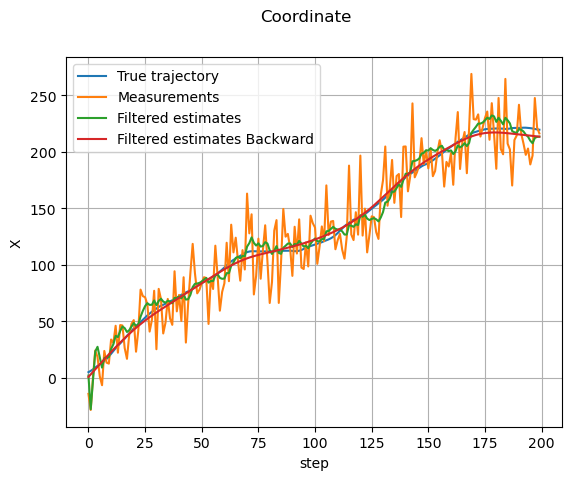

In [9]:
y1 = Xt[0][0]
y2 = Z[0][0]
y3 = Xf[0][0]
y4 = Xb[0][0]
x = step
plt.plot(x,y1,label = 'True trajectory')
plt.plot(x,y2,label = 'Measurements')
plt.plot(x,y3,label = 'Filtered estimates')
plt.plot(x,y4,label = 'Filtered estimates Backward')
plt.xlabel('step')
plt.ylabel('X')
plt.suptitle('Coordinate')
plt.legend()
plt.grid(True)

In [10]:
#------------№4------------
def calculate_MSE(N, M, x0, sigma, sigma1, Fi, G, H, Q, R, X0, P0):
    Error_run = np.zeros((2, M, N))
    final_Error = np.zeros((2, 1, N-3))
    Error_run1 = np.zeros((2, M, N))
    final_Error1 = np.zeros((2, 1, N-3))

    for i in range(M):
        Xt = generate_Xt(x0, sigma, Fi, G, N)
        Z = generate_Z(sigma1, Xt, H, N)
        Xf, Pf, K, Ps, Pp = kalmanFilter(Fi, H, Q, R, X0, P0, Z, N)
        Xb, Pb, Ps_back, Xf = kalmanFilter_Backward(Fi, H, Q, R, X0, P0, Z, N)
    

        for j in range(N):
            Error_run[:, i, j] = ((Xt[:, :, j] - Xf[:, :, j])**2).T[0]
            Error_run1[:, i, j] = ((Xt[:, :, j] - Xb[:, :, j])**2).T[0]    
 
    for i in range(N-3):
        for k in range(M):
            final_Error[:, :, i] += Error_run[:, k, i+3].T[0]
            final_Error1[:, :, i] += Error_run1[:, k, i+3].T[0]

        final_Error[:, :, i] = np.sqrt(final_Error[:, :, i] / (M - 1))
        final_Error1[:, :, i] = np.sqrt(final_Error1[:, :, i] / (M - 1))

    return final_Error, final_Error1, Ps, Ps_back

In [11]:
MSEf, MSEb, Ps, Ps_back = calculate_MSE(N,M,x0,sigma,sigma1,Fi,G,H,Q,R,X0,P0)

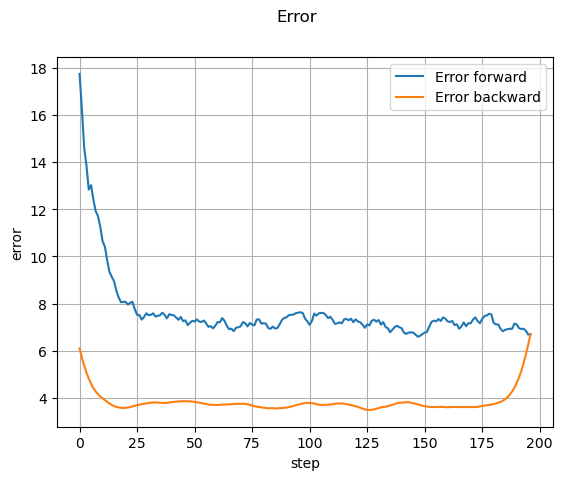

In [12]:
#------------№5------------
y1 = MSEf[0][0]
y2 = MSEb[0][0]
x = step1
plt.plot(x,y1,label = 'Error forward')
plt.plot(x,y2,label = 'Error backward')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

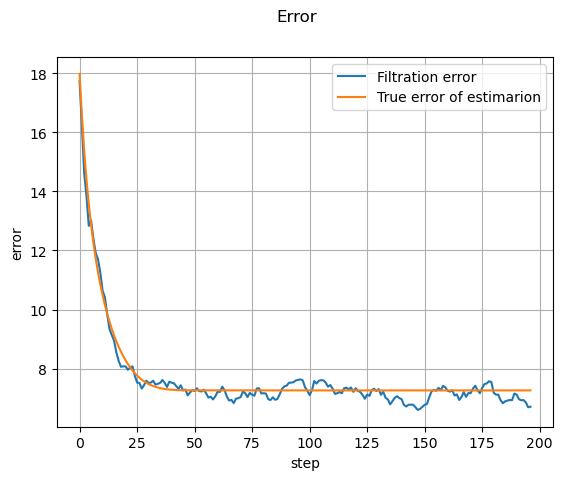

In [13]:
y1 = MSEf[0][0]
y2 = Ps[0, 0, 3:]
x = step1
plt.plot(x,y1,label = 'Filtration error')
plt.plot(x,y2,label = 'True error of estimarion')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)

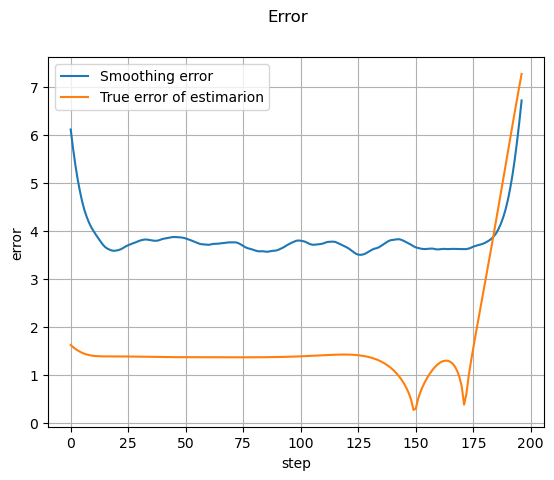

In [14]:
y1 = MSEb[0][0]
y2 = Ps_back[0, 0, 3:]
x = step1
plt.plot(x,y1,label = 'Smoothing error')
plt.plot(x,y2,label = 'True error of estimarion')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error')
plt.legend()
plt.grid(True)